In [28]:
pip install konlpy

In [29]:
pip install keras

In [30]:
pip install tensorflow

In [31]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [32]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7da5b639de80>)

In [33]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [34]:
train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

In [35]:
print(f"(train) len : {len(train_data)}")
print(f"(test) len : {len(test_data)}")

# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print(f"(train) len : {len(train_data)}")
print(f"(test) len : {len(test_data)}")

(train) len : 150000
(test) len : 50000
(train) len : 146183
(test) len : 49158


In [36]:
train_data['label'].value_counts()

,count
label,
0,73342
1,72841


In [37]:
test_data['label'].value_counts()

,count
label,
1,24712
0,24446


In [38]:
train_data.isnull().sum()

,0
document,1
label,0


In [39]:
test_data.isnull().sum()

,0
document,1
label,0


In [40]:
# 결측치 제거
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [41]:
# 한글과 공백 제외 리뷰 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data.head()

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [42]:
# 빈 데이터 제거
train_data = train_data[train_data['document'].str.strip().astype(bool)]
test_data = test_data[test_data['document'].str.strip().astype(bool)]

print(f"(train) len : {len(train_data)}")
print(f"(test) len : {len(test_data)}")

(train) len : 145393
(test) len : 48852


In [43]:
!apt-get install -y openjdk-11-jdk

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.environ["JAVA_HOME"] + "/bin"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [44]:
# 토큰화
okt = Okt()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어
X_train = []

for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_train[:3]

100%|██████████| 145393/145393 [12:27<00:00, 194.61it/s]


[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [45]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [04:40<00:00, 174.32it/s]


In [46]:
# 희귀 단어 비율 확인
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어 수
rare_cnt = 0 # 등장 빈도가 3보다 작은 단어 수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도가 3보다 작은 단어의 등장 빈도의 총 합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어수 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어 수: %s'%(threshold - 1, rare_cnt))
print("희귀 단어 사용 비율:", (rare_freq / total_freq)*100)


단어수 : 43752
등장 빈도가 2번 이하인 희귀 단어 수: 24337
희귀 단어 사용 비율: 1.8715872104872904


In [47]:
# 인코딩
tokenizer = Tokenizer(total_cnt - rare_cnt + 1) # 희귀 단어 제거
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [48]:
# 희귀 단어 제거 후 다시 결측치 제거
drop_train = [i for i, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = [x for i, x in enumerate(X_train) if i not in drop_train]
y_train = [y for i, y in enumerate(y_train) if i not in drop_train]

print(len(X_train))
print(len(y_train))


145162
145162


리뷰의 평균 길이 : 10.812485361182679


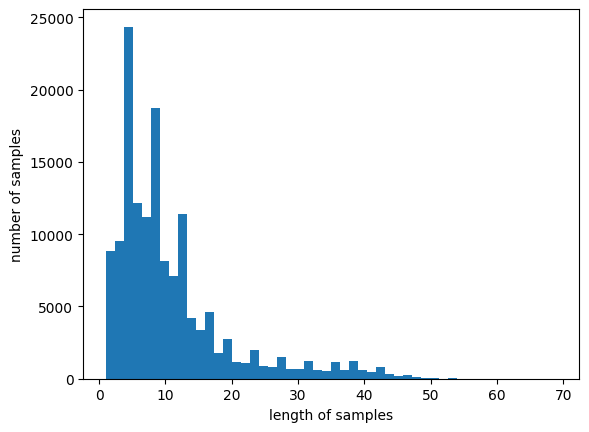

In [49]:
# 리뷰 길이 분포
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [50]:
# 길이 이하 리뷰 비율
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(20, X_train)
below_threshold_len(25, X_train)
below_threshold_len(30, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 88.18836885686336
전체 샘플 중 길이가 25 이하인 샘플의 비율: 91.77884019233684
전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [51]:
# 패딩
max_len = 30
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [53]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.2 MB/s eta 0:00:00


X_train type: <class 'numpy.ndarray'>
y_train type: <class 'list'>
X_train shape: (145162, 30)
y_train shape: (145162,)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

def build_model(hp):
    model = Sequential()

    embedding_dim = hp.Choice('embedding_dim', values=[50, 100, 200])
    model.add(Embedding(total_cnt - rare_cnt + 1, embedding_dim))
    units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    model.add(Bidirectional(LSTM(units)))
    model.add(Dense(1, activation='sigmoid'))

    # 최적화기 선택
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

y_train = np.array(y_train)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_tuner',
    project_name='sentiment_bilstm'
)

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

tuner.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=64,
    callbacks=[es]
)

best_model = tuner.get_best_models(num_models=1)[0]

# 최종 모델 학습
history = best_model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es]
)


Trial 5 Complete [00h 01m 26s]
val_accuracy: 0.8516860008239746

Best val_accuracy So Far: 0.8533737659454346
Total elapsed time: 00h 23m 54s
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1815/1815 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9022 - loss: 0.2357 - val_accuracy: 0.8519 - val_loss: 0.3546
Epoch 2/15
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9208 - loss: 0.1961 - val_accuracy: 0.8477 - val_loss: 0.3904
Epoch 3/15
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9379 - loss: 0.1582 - val_accuracy: 0.8448 - val_loss: 0.4471
Epoch 4/15
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9515 - loss: 0.1250 - val_accuracy: 0.8412 - val_loss: 0.5450
Epoch 4: early stopping


In [59]:
loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"테스트 정확도: {acc:.4f}")

테스트 정확도: 0.8381


In [61]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(best_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
97.50% 확률로 긍정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
98.04% 확률로 부정 리뷰입니다.



/tmp/ipython-input-2351036619.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(best_model.predict(pad_new)) # 예측
